In [1]:
import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
from scipy.stats import kendalltau

from IPython.display import display

from functions import integrate_model,CompartmentalChainModel,CompartmentalModel_from_Reactions


# Markov chain approximation for compartmental models

We first load the adjacency matrix `Wij` of the network of contacts, and the metadata, for a particular setting

In [2]:
setting = 'hospital' 
contact_meta= pd.read_csv('Data/meta_{}.csv'.format(setting))
Wij= np.loadtxt('Data/wij_{}.np'.format(setting))

We create some models. The simplest way is to consider a disease which evolves by a chain of transitions.
After creating the model, we calibrate it so later we can prescribe a final size instead of the rate of transmission `beta`, to make more easy the comparison among models.



In [122]:
mu = 1.0
epsilon = 1.0
list_of_param= [  
                  ('SIR', 0.01, [1,0], [mu, 0]),
                  ('SEIR', 0.01, [0,1,0], [epsilon, mu, 0]),
                  ('SEIRe2', 0.01, [0,1,0], [epsilon / 2, mu, 0]),
                  ('SEIRe4', 0.01, [0,1,0], [epsilon / 4, mu, 0]),
                  ('SEIR std 0.5', 0.01/4, [0, 0, 0, 0, 1, 1, 1, 1, 0],
                   [epsilon*4 for i in range(4)] + [mu*4 for i in range(4)]+ [0]),
                  ('SEIQIR', 0.01, [0,1,0,1,0], [epsilon*2, mu*2, epsilon*2, mu*2, 0]),
                  ]

dict_of_models = {}
for name, dt, rbeta, rates in list_of_param:
    print(name,' ',)
    model = CompartmentalChainModel(name = name,
                                    Wij = Wij, 
                                    dt = dt,
                                    rbeta = np.array( rbeta), 
                                    rates = np.array(rates),
                                    )   
    model.calibrate_size(0.001,1.0)
    dict_of_models[name] =  model



 SIR

 SEIR

 SEIRe2

 SEIRe4

 SEIR shape 3

 SEIQIR


We can also create more complex model by defining reactions in the form of triplets `(reactant, product, rate)`. We include a model for COVID and antoher more exotic where the disease cycles among different infectious states.

In [123]:
# ----------- COVID model ---------
list_of_reactions= [ 
      ('E', 'I', 7/4 ),
      ('I', 'Ic', 7/1.8 ),
      ('I', 'Isc', 7/1.8 ),
      ('Ic', 'R', 7/5 ),
      ('Isc', 'R', 7/5 ),
     ]
states    = ['E','I', 'Ic', 'Isc','R']     
rbeta = [ 0,  0.5, 1,   0.5,   0]
model = CompartmentalModel_from_Reactions(
                            name = 'COVID',
                            Wij = Wij, dt = dt,
                            rbeta = np.array( rbeta), 
                            states = states,
                            list_of_reactions = list_of_reactions,
                            )   
model.calibrate_size(0.001,1.0)
dict_of_models[model.name] =  model

# ----------- Cycling model ---------
r1 = 1
r2 = 0.5
list_of_reactions = [ 
     ('E','I1', r1 ),
     ('I1','I2', r1 ),
     ('I2','I3', r1 ),
     ('I3','I4', r1 ),
     ('I4','I1', r1 ),     
     ('I2','R', r2 ),
     ('I4','R', r2 ),  
]
states    = ['E','I1','I2','I3','I4','R']     
rbeta = [ 0,  1.0, 1.0,   0.25, 0.125,  0]
model = CompartmentalModel_from_Reactions(
                            name = 'CYCLE',
                            Wij = Wij, dt = dt,
                            rbeta = np.array( rbeta), 
                            states = states,
                            list_of_reactions = list_of_reactions,
                            )   

model.calibrate_size(0.001,1.0)
dict_of_models[model.name] =  model


We can plot the result of the calibration

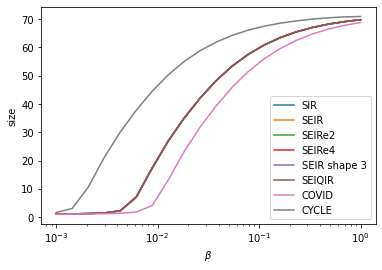

In [124]:
for model in dict_of_models.values():
    plt.plot(model.BETAS,model.SIZES,label=model.name)
plt.ylabel('size')
plt.xlabel('$\\beta$')    
plt.xscale('log')
plt.legend()   
plt.show()

Also we can plot the expected number of individuals in each compartment in function of time, for a given attack rate. Here for example we plot the evolution in the SEIR model.

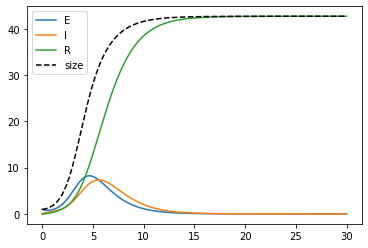

In [127]:
tmax = 30
attack = 71*0.6
model = dict_of_models['SEIR']
s = model.run_calsize(attack, tmax)
s = np.array(s)
time = np.arange(s.shape[0])*model.dt

plt.plot(time,s[:,0],label = list('EIR') )
plt.plot(time,s.sum(axis=2),'k--',label = 'size' )
plt.legend()
plt.show()